In [14]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

import sys
import os
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import obspy
# from tqdm import tqdm
from glob import glob
import time
import random
import sys
from datetime import datetime
from tqdm import tqdm

from scipy import stats,signal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
import pickle

import numpy as np
import scipy.signal as signal



# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Get the current working directory
notebook_dir = os.getcwd()

# Add the ../src directory to the Python path
src_path = os.path.abspath(os.path.join(notebook_dir, 'scripts'))
sys.path.insert(0, src_path)

sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
sys.path.append('../src')

from neural_network_architectures import QuakeXNet_1d
from neural_network_architectures import QuakeXNet_2d
from neural_network_architectures import QuakeXNet_1d_on_2d

from neural_network_architectures import SeismicCNN_1d
from neural_network_architectures import SeismicCNN_2d

from neural_network_architectures import BasicResNet_1d
from neural_network_architectures import BasicResNet_2d


from helper_functions import extract_waveforms
from helper_functions import extract_spectrograms
from helper_functions import return_train_test_val_loaders
from helper_functions import train_model
from helper_functions import plot_confusion_matrix_and_cr
from helper_functions import return_train_val_loaders

import json

from utils import plot_confusion_matrix
from utils import plot_classification_report


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


## Loading the trained models

In [15]:
## setting up some important parameters (not to be changed)
num_channels = 3
dropout = 0.9
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## initiating the model architectures - 
#model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available



# Load the saved model state dict (weights)
saved_model_seismiccnn_1d = torch.load('trained_models/best_model_SeismicCNN_1d.pth', map_location=torch.device('cpu'))  # No'weights_only' argument

# Load the saved model state dict (weights)
saved_model_seismiccnn_2d = torch.load('trained_models/best_model_SeismicCNN_2d.pth', map_location=torch.device('cpu'))  # No'weights_only' argument

# Load the saved model state dict (weights)
saved_model_quakexnet_1d = torch.load('trained_models/best_model_QuakeXNet_1d.pth', map_location=torch.device('cpu'))  # No 'weights_only' argument


# Load the saved model state dict (weights)
saved_model_quakexnet_2d = torch.load('trained_models/best_model_QuakeXNet_2d.pth', map_location=torch.device('cpu'))  # No 'weights_only' argument



# Load the state dict into the model
model_seismiccnn_1d.load_state_dict(saved_model_seismiccnn_1d)
model_quakexnet_1d.load_state_dict(saved_model_quakexnet_1d)
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)


# Move the model to the correct device (GPU or CPU)
model_seismiccnn_1d.to(device)
model_quakexnet_1d.to(device)
model_seismiccnn_2d.to(device)
model_quakexnet_2d.to(device)


# Put the model in evaluation mode (important for models with dropout/batch norm layers)
model_seismiccnn_1d.eval()
model_quakexnet_1d.eval()
model_seismiccnn_2d.eval()
model_quakexnet_2d.eval()

/tmp/ipykernel_325149/1591889725.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_1d = torch.load('trained_models/best_model_SeismicCNN_1d.pth', m

QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): Bat

## Loading on the common dataset

In [16]:
test_waveforms_1d = np.load('../data/common_test_data_for_deep_learning.npy')
test_labels = np.load('../data/common_test_data_labels_for_deep_learning.npy')

test_waveforms_2d = extract_spectrograms(test_waveforms_1d)

100%|██████████| 8000/8000 [00:11<00:00, 710.37it/s] 

(8000, 3, 129, 38)


## Creating the dataloaders

In [17]:
batch_size = 128
custom_dataset_1d = TensorDataset(torch.Tensor(test_waveforms_1d),torch.Tensor(test_labels).float())
test_loader_1d = DataLoader(custom_dataset_1d, batch_size = batch_size, shuffle=True,drop_last=True)

custom_dataset_2d = TensorDataset(torch.Tensor(test_waveforms_2d),torch.Tensor(test_labels).float())
test_loader_2d = DataLoader(custom_dataset_2d, batch_size = batch_size, shuffle=True,drop_last=True)

## Saving the results

In [23]:
criterion=nn.CrossEntropyLoss()
batch_size = 128

def plot_confusion_matrix_and_cr(model, test_loader, show_plot = True, criterion = criterion, batch_size = batch_size):
    
    
    
    classes = ['earthquake', 'explosion','noise', 'surface']

    with torch.no_grad(): # Context-manager that disabled gradient calculation.
        # Loop on samples in test set
        total = 0
        correct = 0
        running_test_loss = 0

        y_pred=np.zeros(len(test_loader)*batch_size)
        y_test=np.zeros(len(test_loader)*batch_size)

        model_inference_time = 0
        
        
        for i, data in enumerate(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()
            labels = labels.long()
            
            stime = time.time()
            outputs = model(inputs)
            etime = time.time() - stime
            model_inference_time += etime

            y_pred[i*batch_size:(i+1)*batch_size]=outputs.argmax(1).cpu().numpy()
            y_test[i*batch_size:(i+1)*batch_size]=labels.cpu().numpy()

            running_test_loss += criterion(outputs, labels).item()

            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)


        test_loss = running_test_loss/len(test_loader)
        test_accuracy = 100 * correct / total  
        print('test loss: %.3f and accuracy: %.3f' % ( test_loss,test_accuracy))

        model_inference_time_per_sample = model_inference_time/len(y_test)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred, output_dict=True)

        
        holder = str(model).split('(')[0]
        
        
        
        # saving trace wise report
        with open('../results/common_test_report_'+holder+'.pkl', 'wb') as pickle_file:
            pickle.dump(cr, pickle_file)

        # saving trace wise confusion matrix
        with open('../results/common_test_confusion_matrix_'+holder+'.pkl', 'wb') as pickle_file:
            pickle.dump(cm, pickle_file)
            
        
        # saving trace wise confusion matrix
        with open('../results/common_test_model_inference_time_per_sample_'+holder+'.pkl', 'wb') as pickle_file:
            pickle.dump(model_inference_time_per_sample, pickle_file)
            
    
        if show_plot:
            plot_confusion_matrix(cm,  figure_name = '../figures/confusion_matrix_common_test_data_'+holder+'.png')
            plot_classification_report(cr, figure_name = '../figures/confusion_matrix_common_test_data_'+holder+'.png')
            
            
         
        return cm, cr
    
            
            
            
            
            

test loss: 0.480 and accuracy: 84.274


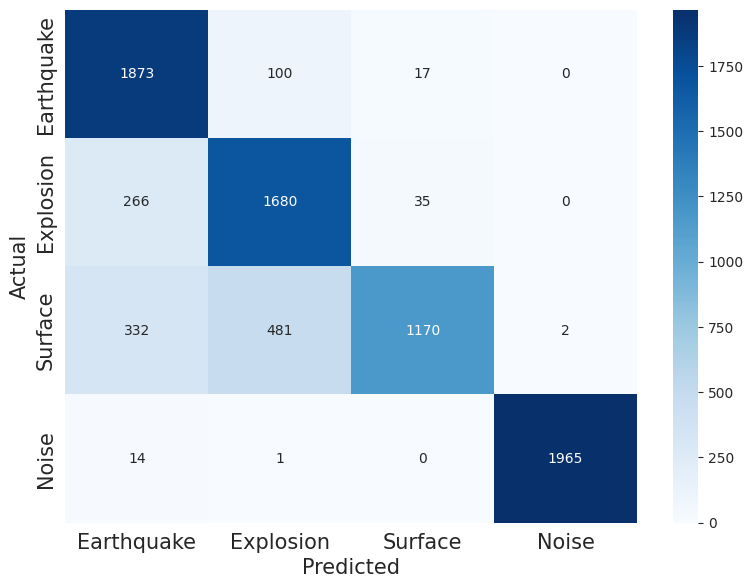

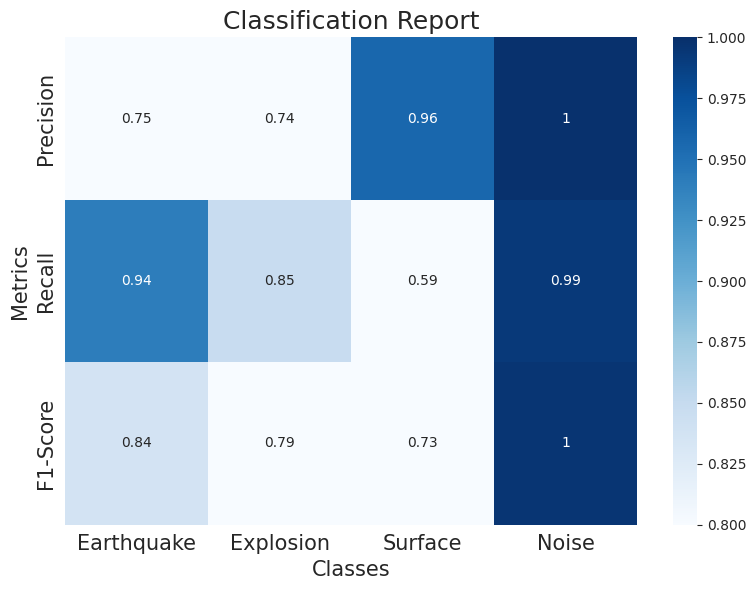

In [24]:
model = model_seismiccnn_1d
cm_seismiccnn_1d, cr_seismiccnn_1d = plot_confusion_matrix_and_cr(model, test_loader_1d)

test loss: 0.204 and accuracy: 93.674


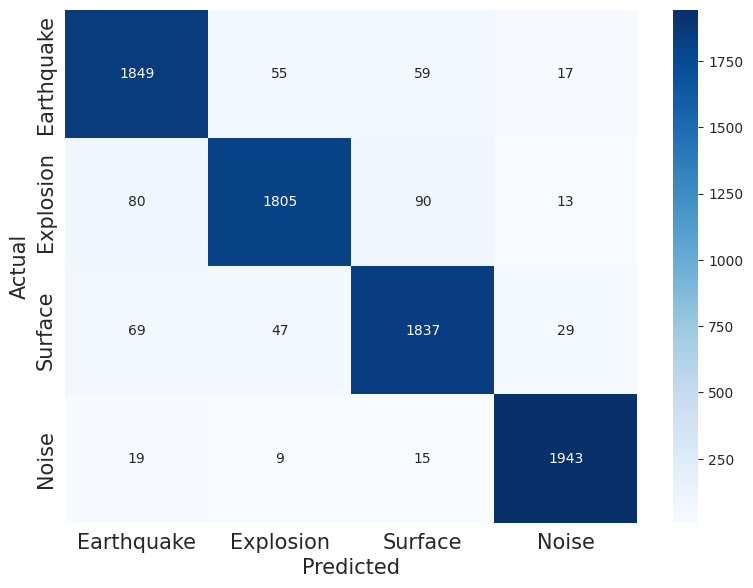

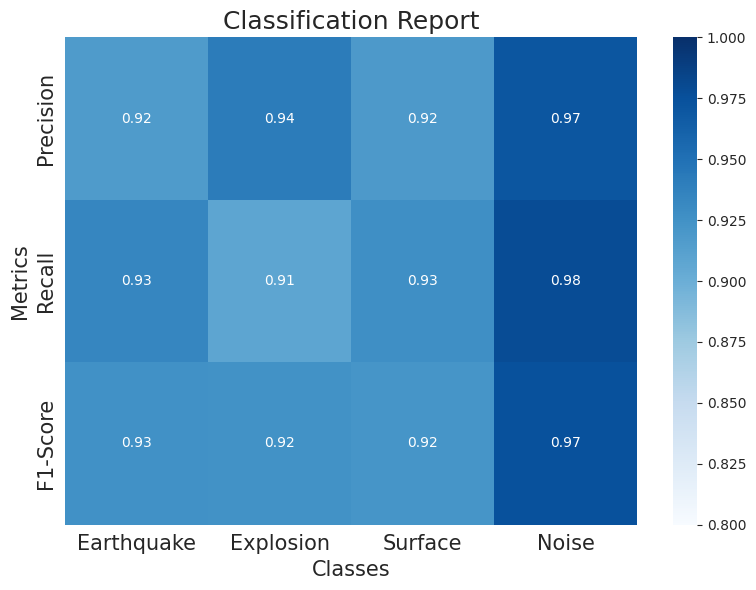

In [25]:
model = model_seismiccnn_2d
cm_seismiccnn_2d, cr_seismiccnn_2d = plot_confusion_matrix_and_cr(model, test_loader_2d)

test loss: 0.235 and accuracy: 91.683


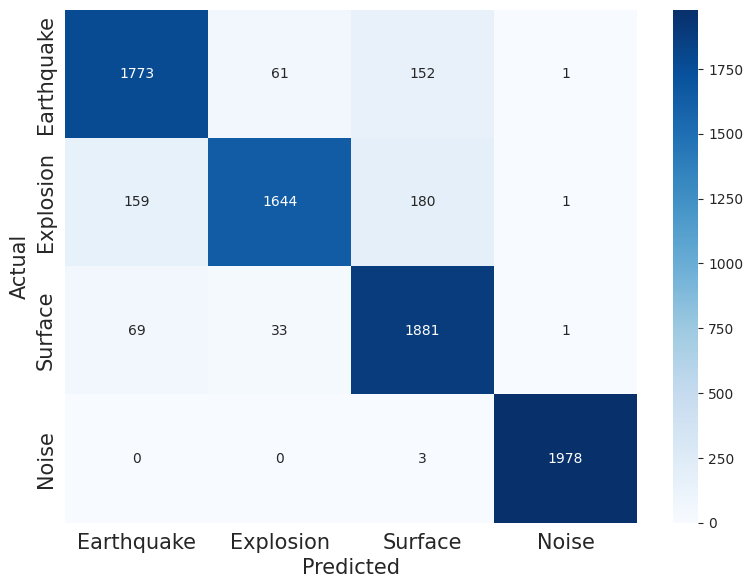

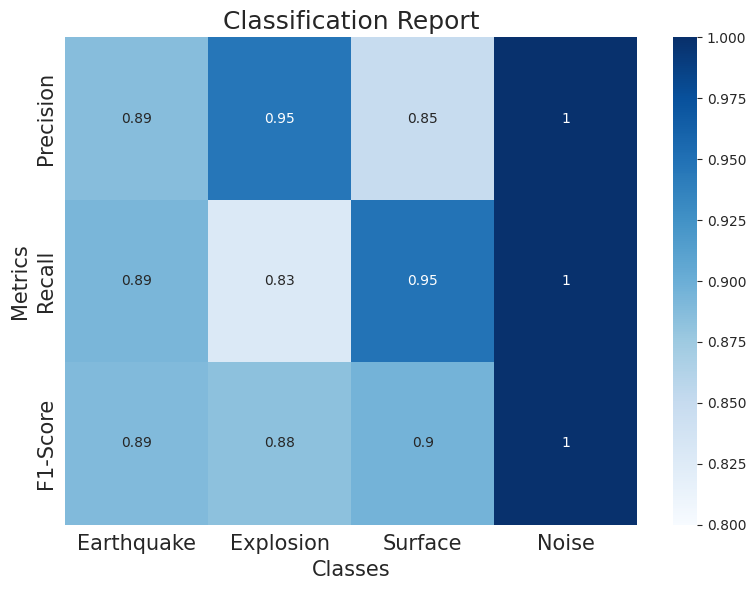

In [26]:
model = model_quakexnet_1d
cm_quakexnet_1d, cr_quakexnet_1d = plot_confusion_matrix_and_cr(model, test_loader_1d)

test loss: 0.223 and accuracy: 92.364


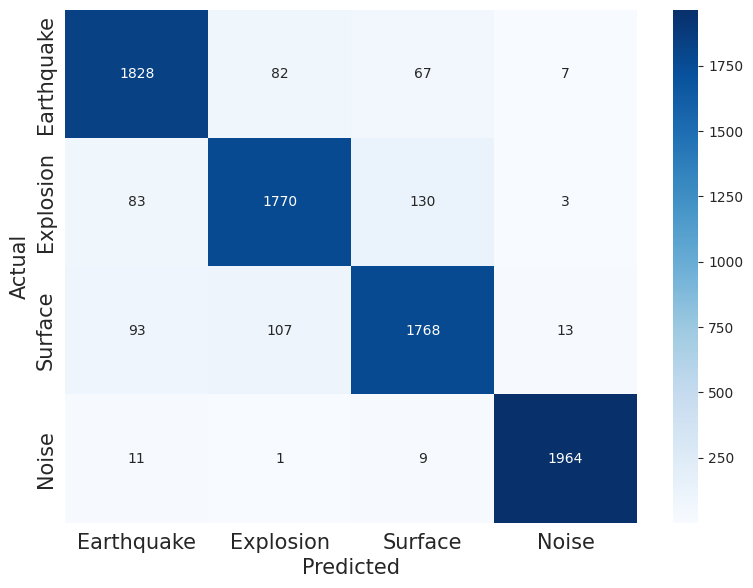

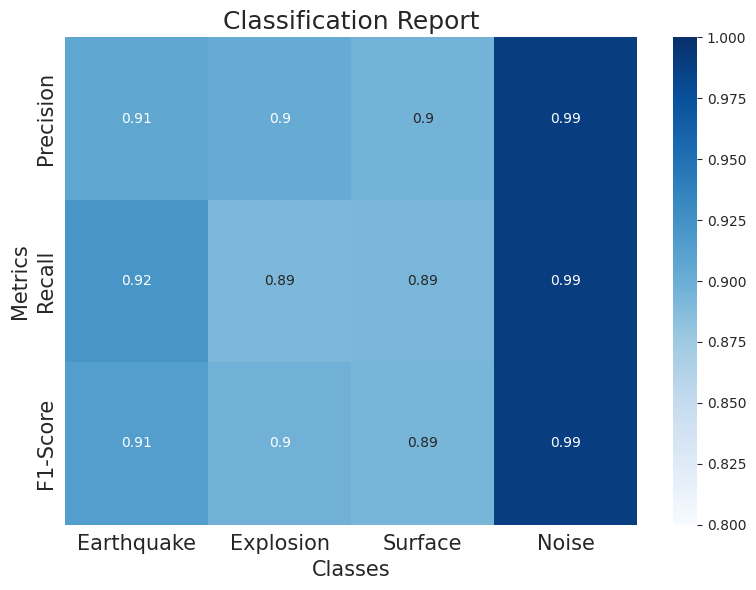

In [27]:
model = model_quakexnet_2d
cm_quakexnet_2d, cr_quakexnet_2d = plot_confusion_matrix_and_cr(model, test_loader_2d)